In [13]:
import cv2

import numpy as np

import matplotlib.pyplot as plt

from skimage.filters import threshold_otsu

import scipy
from scipy.signal import convolve
from scipy.signal import correlate
from scipy import ndimage

import os

In [14]:
def unsharp_mask(img, intensity):
    '''
    np.array, float -> np.array
    Realça as bordas através da aplicação do unsharp mask 
    (convolução do filtro identidade - filtro laplaciano ponderado).
    
    Parâmetros
    ----------
    img : imagem de entrada a ser realçada pela técnica.
    intensity: intensidade da ponderação do realce de bordas.
    
    Return
    ------
    Numpy array contendo a imagem com bordas destacadas através do unsharp mask.
    '''
    kernel = np.array([[0,             -1*intensity,              0],
                       [-1*intensity,  (4*intensity)+1, -1*intensity],
                       [0,             -1*intensity,              0]])
    return convolve(img, kernel, mode='same')

(1, 31, 3)


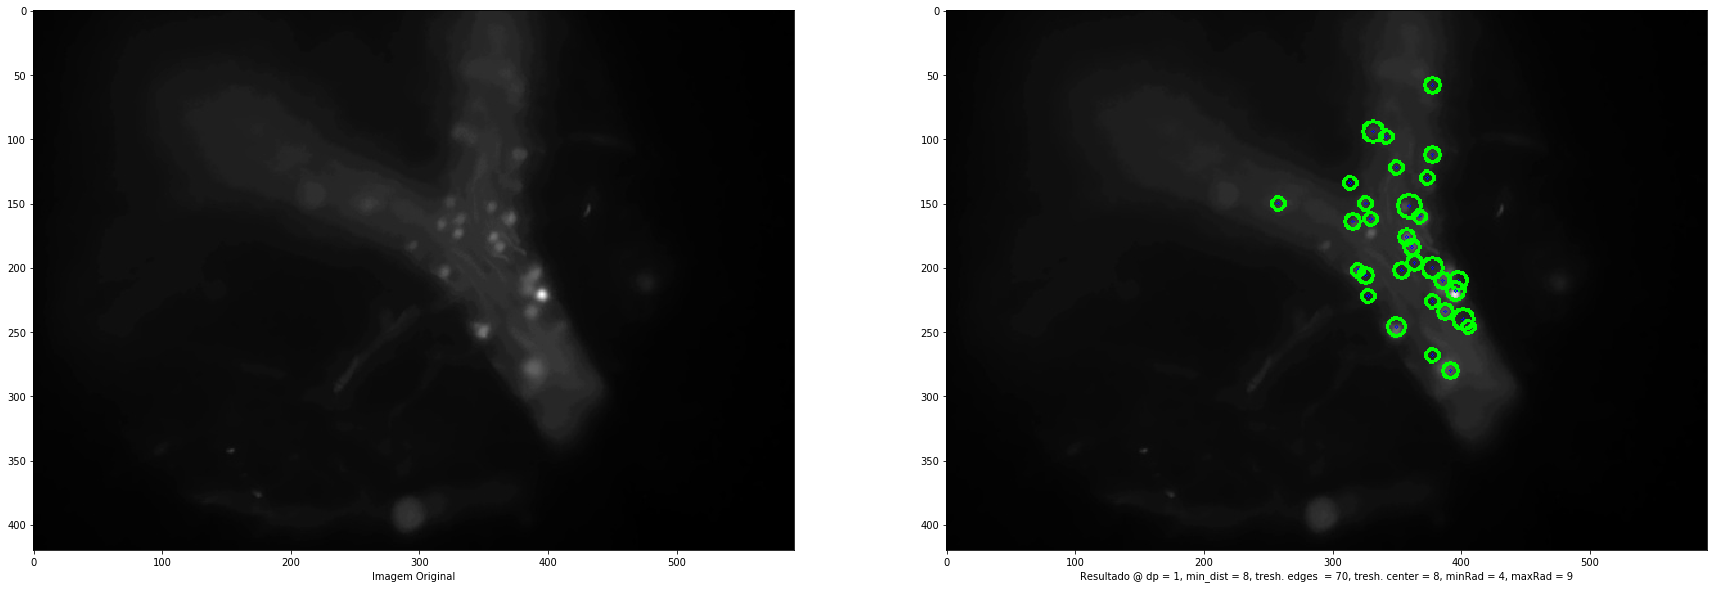

In [72]:
'''TESTE DA APLICAÇÃO DA TRANSFORMADA SOBRE UMA IMAGEM EM TONS DE CINZA'''
#Carregando a Máscara
mask = cv2.imread('maskt1.png',0)

#Abertura da imagem
img = cv2.imread('teste35.jpg',0)

#Conversão para RGB, para sobrepor os círculos encontrados
cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)

#Aplicação do unsharp mask para o destaque de bordas
img_enhanced = unsharp_mask(img, 1)
   
#Aplicação da máscara
img_enhanced_masked = np.multiply(img_enhanced,mask)

#Conversão para uint8, requisito do método
img_enhanced_masked_uint8 = np.uint8(img_enhanced_masked)
        


#Definição dos parâmetros 
par_dp = 1        #The inverse ratio of resolution || Resolução da matriz acumuladora 
par_min_dist = 8  #Minimum distance between detected centers || Mínima distância entre os circulos detectados
par_param1 = 70   #Upper threshold for the internal Canny edge detector || Limite superior para o detector de bordas interno 
par_param2 = 8    #Threshold for center detection. || Rigidez do votador responsável pelo julgamento dos candidatos a círculos detectados
par_minRadius = 4 #mMinimum radio to be detected. If unknown, put zero as default. || Raio de busca mínimo
par_maxRadius = 9 #Maximum radius to be detected. If unknown, put zero as default || Raio de busca máximo
    
#Aplicação da Técnica
circles = cv2.HoughCircles(img_enhanced_masked_uint8, #Input image (grayscale, uint8)
                            cv2.HOUGH_GRADIENT,            #CV_HOUGH_GRADIENT: Define the detection method. Currently this is the only one available in OpenCV
                            par_dp,par_min_dist,param1=par_param1,param2=par_param2,minRadius=par_minRadius,maxRadius=par_maxRadius)

circles_centers = circles[:,:,0:2]

print circles.shape #A vector that stores sets of 3 values: x_{c}, y_{c}, r for each detected circle.
#print circles_centers

#Inseração dos circulos detectados sobre as imagens 
circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv2.circle(cimg,(i[0],i[1]),1,(0,0,255),1)
    
    
#Plot das imagens
plt.figure(figsize=[30, 30])
plt.subplot(1,2,1)
plt.imshow(img, "gray")
plt.xlabel("Imagem Original")
plt.subplot(1,2,2)
plt.xlabel("Resultado @ dp = {}, min_dist = {}, tresh. edges  = {}, tresh. center = {}, minRad = {}, maxRad = {}".format(par_dp, par_min_dist, par_param1, par_param2, par_minRadius, par_maxRadius))
plt.imshow(cimg, "gray")

which =28
#print circles.shape
#print circles[0,:,:]
#print circles[0,which,:]
#cv2.circle(cimg,(circles[0,which,0],circles[0,which,1]),circles[0,which,2],(0,0,255),2)
#plt.imshow(cimg,"gray")
#cimg.shape

In [73]:
def leukocyte_profile(frame, detected_circle):
    y,x,r = detected_circle
    window = frame[x-r-5:x+r+5,y-r-5:y+r+5]
    
    maximal_point = np.unravel_index(window.argmax(), window.shape)
    print  maximal_point
    
    window_reframed = window[maximal_point[0]-r:maximal_point[0]+r,maximal_point[1]-r:maximal_point[1]+r]
    
    #-- Extract the line...
    # Make a line with "num" points...
    window_rows, window_cols = window_reframed.shape
    x0_v, y0_v = window_rows//2, 0
    x1_v, y1_v = window_rows//2, window_cols
    num = 50
    x, y = np.linspace(x0_v, x1_v, num), np.linspace(y0_v, y1_v, num)
    
    # Extract the values along the line, using cubic interpolation
    profile_v = scipy.ndimage.map_coordinates(window_reframed, np.vstack((x,y)))
    
    #-- Extract the line...
    # Make a line with "num" points...
    x0_h, y0_h = 0, window_cols//2
    x1_h, y1_h = window_rows, window_cols//2
    x, y = np.linspace(x0_h, x1_h, num), np.linspace(y0_h, y1_h, num)
    
    # Extract the values along the line, using cubic interpolation
    profile_h = scipy.ndimage.map_coordinates(window_reframed, np.vstack((x,y)))

    #-- Extract the line...
    # Make a line with "num" points...
    x0_minus, y0_minus = 0, 0
    x1_minus, y1_minus = window_rows, window_cols
    x, y = np.linspace(x0_minus, x1_minus, num), np.linspace(y0_minus, y1_minus, num)
    
    # Extract the values along the line, using cubic interpolation
    profile_minus = scipy.ndimage.map_coordinates(window_reframed, np.vstack((x,y)))

    #-- Extract the line...
    # Make a line with "num" points...
    x0_plus, y0_plus = window_rows, 0
    x1_plus, y1_plus = 0, window_cols
    x, y = np.linspace(x0_plus, x1_plus, num), np.linspace(y0_plus, y1_plus, num)
    
    # Extract the values along the line, using cubic interpolation
    profile_plus = scipy.ndimage.map_coordinates(window_reframed, np.vstack((x,y)))
    
    profile_v = profile_v / np.linalg.norm(profile_v)
    profile_h = profile_h / np.linalg.norm(profile_h)
    profile_minus = profile_minus / np.linalg.norm(profile_minus)
    profile_plus = profile_plus / np.linalg.norm(profile_plus)
    
    avg_profile = (profile_v+profile_h+profile_plus+profile_minus) / 4
    #-- Plot...
    fig, axes = plt.subplots(nrows=2)
    axes[0].imshow(window_reframed)
    axes[0].plot([x0_v, x1_v], [y0_v, y1_v], 'ro-')
    axes[0].plot([x0_h, x1_h], [y0_h, y1_h], 'go-')
    axes[0].plot([x0_minus, x1_minus], [y0_minus, y1_minus], 'bo-')
    axes[0].plot([x0_plus, x1_plus], [y0_plus, y1_plus], 'co-')
    axes[0].axis('image')
    
    axes[1].plot(profile_v,'r')
    axes[1].plot(profile_h,'g')
    axes[1].plot(profile_minus,'b')
    axes[1].plot(profile_plus,'c')
    axes[1].plot(avg_profile, 'y')
    
    #print avg_profile.shape, profile_v.shape
    
    print np.mean(correlate(avg_profile, profile_v))
    print np.mean(correlate(avg_profile, profile_h))
    print np.mean(correlate(avg_profile, profile_minus))
    print np.mean(correlate(avg_profile, profile_plus))
    
    plt.show()


    return window_reframed


(15, 11)
0.3935562172726481
0.3910610988791499
0.37575368625996197
0.3567157906102214


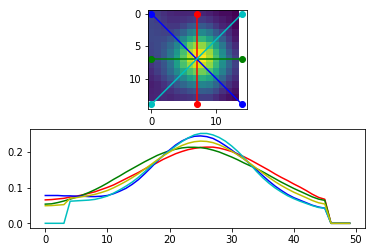

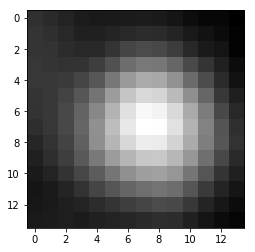

In [74]:
leukocyte = leukocyte_profile(img,circles[0,which,:])
plt.imshow(leukocyte, "gray")